In [1]:
from IPython.core.magic import register_cell_magic
import os
from pathlib import Path

## define custom magic to save most useful classes and use them in inference notebook 
## instead of copying the code every time you have changes in the classes
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)
    
Path('/kaggle/working/scripts').mkdir(exist_ok=True)
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(exist_ok=True)

In [2]:
%%write_and_run scripts/imports.py

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler, Sampler
from torch.nn.functional import mse_loss
from transformers import AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup, AutoConfig, AdamW
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
# print(plt.style.available)
from time import time
from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
g_ = Fore.GREEN
y_ = Fore.YELLOW
w_ = Fore.WHITE
bb_ = Back.BLACK
sr_ = Style.RESET_ALL

In [3]:
%%write_and_run scripts/config.py

class Config:
    model_name = 'roberta-large'
    output_hidden_states = True
    epochs = 3
#     evaluate_interval = 40
    batch_size = 8
    device = 'cuda'
    seed = 2021
    max_len = 248
    lr = 1e-5
    wd = 0.01
#     eval_schedule = [(float('inf'), 40), (0.5, 30), (0.49, 20), (0.48, 10), (0.47, 3), (0, 0)]
    eval_schedule = [(float('inf'), 40), (0.47, 20), (0.46, 10), (0, 0)]

    gradient_accumulation = 2

In [4]:
def seed_everything(seed=2021):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=Config.seed)

In [5]:
# train_df = pd.read_csv('../input/k/chamecall/train-val-split/train.csv')
# val_df = pd.read_csv('../input/k/chamecall/train-val-split/val.csv')

kfold_df = pd.read_csv('../input/train-val-split/kfold.csv')

In [6]:
%%write_and_run scripts/dataset.py

from torch.utils.data import Dataset
import torch

def convert_examples_to_features(text, tokenizer, max_len):

    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        truncation=True,
        padding='max_length',
    )
    return tok


class CLRPDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.tolist()
        if not is_test:
            self.targets = self.data.target.tolist()
            
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:
            excerpt = self.excerpts[item]
            label = self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

In [7]:
%%write_and_run scripts/model.py

import torch
import torch.nn as nn

class AttentionHead(nn.Module):
    def __init__(self, h_size, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(h_size, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class CLRPModel(nn.Module):
    def __init__(self,transformer,config):
        super(CLRPModel,self).__init__()
        self.h_size = config.hidden_size
        self.transformer = transformer
        self.head = AttentionHead(self.h_size*4)
        self.linear = nn.Linear(self.h_size*2, 1)
        self.linear_out = nn.Linear(self.h_size*8, 1)

              
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer(input_ids, attention_mask)
       
        all_hidden_states = torch.stack(transformer_out.hidden_states)
        cat_over_last_layers = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]),-1
        )
        
        cls_pooling = cat_over_last_layers[:, 0]   
        head_logits = self.head(cat_over_last_layers)
        y_hat = self.linear_out(torch.cat([head_logits, cls_pooling], -1))
        
        return y_hat

In [8]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:389]    
    attention_parameters = named_parameters[391:395]
    regressor_parameters = named_parameters[395:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})
    
    # increase lr every second layer
    increase_lr_every_k_layer = 1
    lrs = np.linspace(1, 5, 24 // increase_lr_every_k_layer)
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01
        splitted_name = name.split('.')
        lr = Config.lr
        if len(splitted_name) >= 4 and str.isdigit(splitted_name[3]):
            layer_num = int(splitted_name[3])
            lr = lrs[layer_num // increase_lr_every_k_layer] * Config.lr 

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return optim.AdamW(parameters)

In [9]:
   
    
class DynamicPadCollate:
    def __call__(self,batch):
                
        out = {'input_ids' :[],
               'attention_mask':[],
                'label':[]
        }
        
        for i in batch:
            for k,v in i.items():
                out[k].append(v)
                
        max_pad =0

        for p in out['input_ids']:
            if max_pad < len(p):
                max_pad = len(p)
                    

        for i in range(len(batch)):
            
            input_id = out['input_ids'][i]
            att_mask = out['attention_mask'][i]
            text_len = len(input_id)
            
            out['input_ids'][i] = (out['input_ids'][i].tolist() + [1] * (max_pad - text_len))[:max_pad]
            out['attention_mask'][i] = (out['attention_mask'][i].tolist() + [0] * (max_pad - text_len))[:max_pad]
        
        out['input_ids'] = torch.tensor(out['input_ids'],dtype=torch.long)
        out['attention_mask'] = torch.tensor(out['attention_mask'],dtype=torch.long)
        out['label'] = torch.tensor(out['label'],dtype=torch.float)
        
        return out


class AvgCounter:
    def __init__(self):
        self.reset()
        
    def update(self, loss, n_samples):
        self.loss += loss * n_samples
        self.n_samples += n_samples
        
    def avg(self):
        return self.loss / self.n_samples
    
    def reset(self):
        self.loss = 0
        self.n_samples = 0

class EvaluationScheduler:
    def __init__(self, evaluation_schedule, penalize_factor=1, max_penalty=8):
        self.evaluation_schedule = evaluation_schedule
        self.evaluation_interval = self.evaluation_schedule[0][1]
        self.last_evaluation_step = 0
        self.prev_loss = float('inf')
        self.penalize_factor = penalize_factor
        self.penalty = 0
        self.prev_interval = -1
        self.max_penalty = max_penalty

    def step(self, step):
        # should we to make evaluation right now
        if step >= self.last_evaluation_step + self.evaluation_interval:
            self.last_evaluation_step = step
            return True
        else:
            return False
        
            
    def update_evaluation_interval(self, last_loss):
        # set up evaluation_interval depending on loss value
        cur_interval = -1
        for i, (loss, interval) in enumerate(self.evaluation_schedule[:-1]):
            if self.evaluation_schedule[i+1][0] < last_loss < loss:
                self.evaluation_interval = interval
                cur_interval = i
                break
#         if last_loss > self.prev_loss and self.prev_interval == cur_interval:
#             self.penalty += self.penalize_factor
#             self.penalty = min(self.penalty, self.max_penalty)
#             self.evaluation_interval += self.penalty
#         else:
#             self.penalty = 0
            
        self.prev_loss = last_loss
        self.prev_interval = cur_interval
        
          
        
def make_dataloader(data, tokenizer, is_train=True):
    dataset = CLRPDataset(data, tokenizer=tokenizer, max_len=Config.max_len)
    if is_train:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    batch_dataloader = DataLoader(dataset, sampler=sampler, batch_size=Config.batch_size, pin_memory=True, collate_fn=DynamicPadCollate())
    return batch_dataloader
                   
            
class Trainer:
    def __init__(self, train_dl, val_dl, model, optimizer, scheduler, scaler, criterion, model_num):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = Config.device
        self.batches_per_epoch = len(self.train_dl)
        self.total_batch_steps = self.batches_per_epoch * Config.epochs
        self.criterion = criterion
        self.model_num = model_num
        
        self.scaler = scaler
                
    def run(self):
        record_info = {
            'train_loss': [],
            'val_loss': [],
        }
        
        best_val_loss = float('inf')
        evaluation_scheduler = EvaluationScheduler(Config.eval_schedule)
        train_loss_counter = AvgCounter()
        step = 0
        
        for epoch in range(Config.epochs):
            
            print(f'{r_}Epoch: {epoch+1}/{Config.epochs}{sr_}')
            start_epoch_time = time()
            
            for batch_num, batch in enumerate(self.train_dl):
                train_loss = self.train(batch, step)
#                 print(f'{epoch+1}#[{step+1}/{len(self.train_dl)}]: train loss - {train_loss.item()}')

                train_loss_counter.update(train_loss, len(batch))
                record_info['train_loss'].append((step, train_loss.item()))

                if evaluation_scheduler.step(step):
                    val_loss = self.evaluate()
                    
                    record_info['val_loss'].append((step, val_loss.item()))        
                    print(f'\t\t{epoch+1}#[{batch_num+1}/{self.batches_per_epoch}]: train loss - {train_loss_counter.avg()} | val loss - {val_loss}',)
                    train_loss_counter.reset()

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss.item()
                        print(f"\t\t{g_}Val loss decreased from {best_val_loss} to {val_loss}{sr_}")
                        torch.save(self.model, models_dir / f'best_model_{self.model_num}.pt')
                        
                    evaluation_scheduler.update_evaluation_interval(val_loss.item())
                        
            
                step += 1
            end_epoch_time = time()
            print(f'{bb_}{y_}The epoch took {end_epoch_time - start_epoch_time} sec..{sr_}')

        return record_info, best_val_loss
            

    def train(self, batch, batch_step):
        self.model.train()
        sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
        with autocast():
            preds = self.model(sent_id, mask)
            train_loss = self.criterion(preds, labels.unsqueeze(1))
        
        self.scaler.scale(train_loss).backward()
#         train_loss.backward()
        
        if (batch_step + 1) % Config.gradient_accumulation or batch_step+1 == self.total_batch_steps:
            self.scaler.step(self.optimizer)
            self.scaler.update()
#             self.optimizer.step()
            self.model.zero_grad() 
        self.scheduler.step()
        return torch.sqrt(train_loss)

    def evaluate(self):
        self.model.eval()
        val_loss_counter = AvgCounter()

        for step,batch in enumerate(self.val_dl):
            sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
            with torch.no_grad():
                with autocast():
                    preds = self.model(sent_id, mask)
                    loss = self.criterion(preds,labels.unsqueeze(1))
                val_loss_counter.update(torch.sqrt(loss), len(labels))
        return val_loss_counter.avg()
    
    
def mse_loss(y_true,y_pred):
    return nn.functional.mse_loss(y_true,y_pred)

  Model#1  


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Epoch: 1/3
		1#[41/319]: train loss - 1.0367422103881836 | val loss - 0.7606198191642761
		Val loss decreased from 0.7606198191642761 to 0.7606198191642761
		1#[81/319]: train loss - 0.7215614914894104 | val loss - 0.6088925004005432
		Val loss decreased from 0.6088925004005432 to 0.6088925004005432
		1#[121/319]: train loss - 0.6369322538375854 | val loss - 0.7543479800224304
		1#[161/319]: train loss - 0.6450551152229309 | val loss - 0.5296242833137512
		Val loss decreased from 0.5296242833137512 to 0.5296242833137512
		1#[201/319]: train loss - 0.5992168188095093 | val loss - 0.4988676607608795
		Val loss decreased from 0.4988676607608795 to 0.4988676607608795
		1#[241/319]: train loss - 0.5288516879081726 | val loss - 0.6807166337966919
		1#[281/319]: train loss - 0.650711178779602 | val loss - 0.5176683068275452
The epoch took 322.46461820602417 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.5159848928451538 | val loss - 0.5076009631156921
		2#[42/319]: train loss - 0.42063730955123

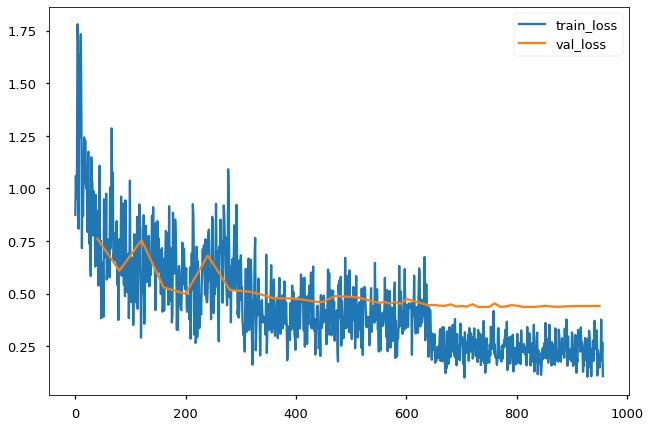

  Model#2  
Epoch: 1/3
		1#[41/319]: train loss - 1.2952038049697876 | val loss - 0.9136241674423218
		Val loss decreased from 0.9136241674423218 to 0.9136241674423218
		1#[81/319]: train loss - 0.7716119885444641 | val loss - 0.604741096496582
		Val loss decreased from 0.604741096496582 to 0.604741096496582
		1#[121/319]: train loss - 0.6375072002410889 | val loss - 0.5732380151748657
		Val loss decreased from 0.5732380151748657 to 0.5732380151748657
		1#[161/319]: train loss - 0.6355534195899963 | val loss - 0.6867048144340515
		1#[201/319]: train loss - 0.6960049271583557 | val loss - 0.644368588924408
		1#[241/319]: train loss - 0.6562839150428772 | val loss - 0.5668883919715881
		Val loss decreased from 0.5668883919715881 to 0.5668883919715881
		1#[281/319]: train loss - 0.5816131234169006 | val loss - 0.5809614658355713
The epoch took 307.41982889175415 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.5244146585464478 | val loss - 0.5489506125450134
		Val loss decreased from 0.548950

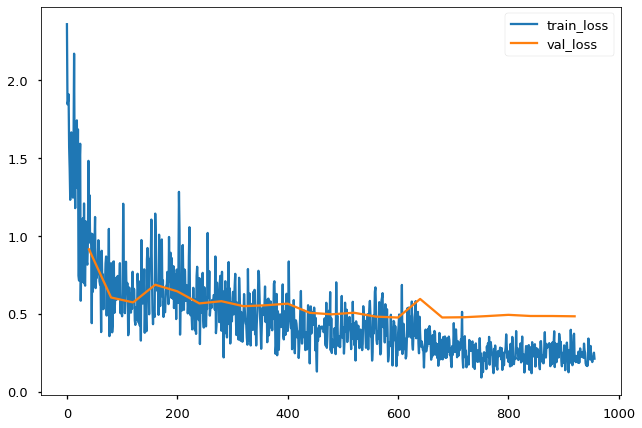

  Model#3  
Epoch: 1/3
		1#[41/319]: train loss - 1.1303330659866333 | val loss - 0.8049721121788025
		Val loss decreased from 0.8049721121788025 to 0.8049721121788025
		1#[81/319]: train loss - 0.7445940971374512 | val loss - 0.6228539347648621
		Val loss decreased from 0.6228539347648621 to 0.6228539347648621
		1#[121/319]: train loss - 0.6628121137619019 | val loss - 0.6139792203903198
		Val loss decreased from 0.6139792203903198 to 0.6139792203903198
		1#[161/319]: train loss - 0.6540666818618774 | val loss - 0.5677257180213928
		Val loss decreased from 0.5677257180213928 to 0.5677257180213928
		1#[201/319]: train loss - 0.6324064135551453 | val loss - 0.5500451922416687
		Val loss decreased from 0.5500451922416687 to 0.5500451922416687
		1#[241/319]: train loss - 0.5500299334526062 | val loss - 0.5526978373527527
		1#[281/319]: train loss - 0.5490754246711731 | val loss - 0.5821613073348999
The epoch took 311.22235918045044 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.576295137405

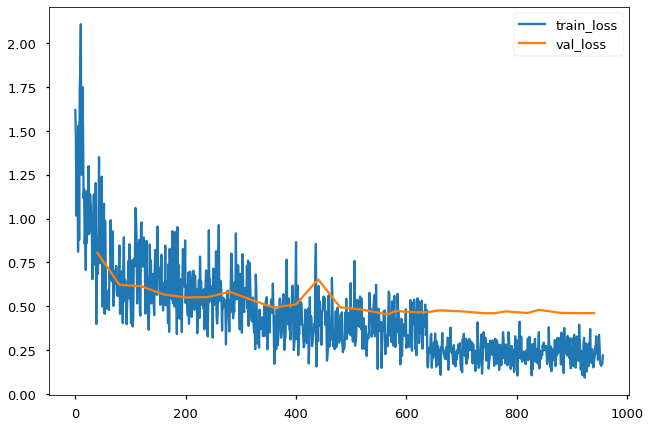

  Model#4  
Epoch: 1/3
		1#[41/319]: train loss - 1.0885783433914185 | val loss - 0.7116140127182007
		Val loss decreased from 0.7116140127182007 to 0.7116140127182007
		1#[81/319]: train loss - 0.6946532130241394 | val loss - 0.6010570526123047
		Val loss decreased from 0.6010570526123047 to 0.6010570526123047
		1#[121/319]: train loss - 0.6674760580062866 | val loss - 0.5817210674285889
		Val loss decreased from 0.5817210674285889 to 0.5817210674285889
		1#[161/319]: train loss - 0.610248327255249 | val loss - 0.5738343000411987
		Val loss decreased from 0.5738343000411987 to 0.5738343000411987
		1#[201/319]: train loss - 0.5904463529586792 | val loss - 0.6185827255249023
		1#[241/319]: train loss - 0.5772271752357483 | val loss - 0.6710991859436035
		1#[281/319]: train loss - 0.5820990204811096 | val loss - 0.5449821352958679
		Val loss decreased from 0.5449821352958679 to 0.5449821352958679
The epoch took 312.94054794311523 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.5767812132835

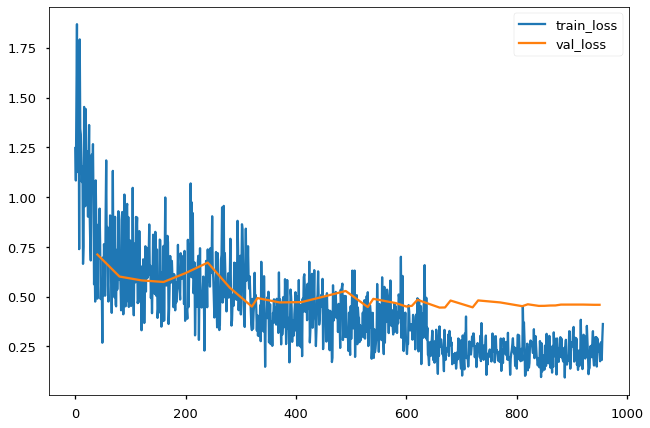

  Model#5  
Epoch: 1/3
		1#[41/319]: train loss - 0.8605787754058838 | val loss - 0.6647656559944153
		Val loss decreased from 0.6647656559944153 to 0.6647656559944153
		1#[81/319]: train loss - 0.7027532458305359 | val loss - 0.5609795451164246
		Val loss decreased from 0.5609795451164246 to 0.5609795451164246
		1#[121/319]: train loss - 0.6558657288551331 | val loss - 0.5521473288536072
		Val loss decreased from 0.5521473288536072 to 0.5521473288536072
		1#[161/319]: train loss - 0.6777418851852417 | val loss - 0.5852264761924744
		1#[201/319]: train loss - 0.6349530220031738 | val loss - 0.6087651252746582
		1#[241/319]: train loss - 0.6258605122566223 | val loss - 0.582018256187439
		1#[281/319]: train loss - 0.5674387812614441 | val loss - 0.47889089584350586
		Val loss decreased from 0.47889089584350586 to 0.47889089584350586
The epoch took 307.5637047290802 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.5789393782615662 | val loss - 0.5522460341453552
		2#[42/319]: train loss - 0.

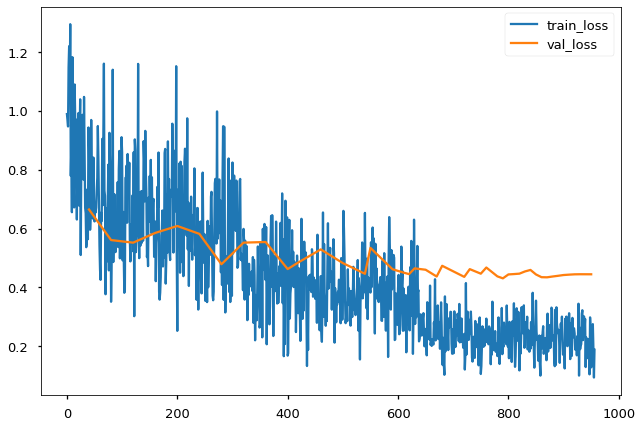

  Model#6  
Epoch: 1/3
		1#[41/319]: train loss - 1.189226746559143 | val loss - 0.9913179278373718
		Val loss decreased from 0.9913179278373718 to 0.9913179278373718
		1#[81/319]: train loss - 0.6983993649482727 | val loss - 0.6704567074775696
		Val loss decreased from 0.6704567074775696 to 0.6704567074775696
		1#[121/319]: train loss - 0.6535918712615967 | val loss - 0.6253870129585266
		Val loss decreased from 0.6253870129585266 to 0.6253870129585266
		1#[161/319]: train loss - 0.6203209757804871 | val loss - 0.556879460811615
		Val loss decreased from 0.556879460811615 to 0.556879460811615
		1#[201/319]: train loss - 0.5984212756156921 | val loss - 0.5477686524391174
		Val loss decreased from 0.5477686524391174 to 0.5477686524391174
		1#[241/319]: train loss - 0.5148889422416687 | val loss - 0.5460716485977173
		Val loss decreased from 0.5460716485977173 to 0.5460716485977173
		1#[281/319]: train loss - 0.5224272012710571 | val loss - 0.5093467831611633
		Val loss decreased from 0.

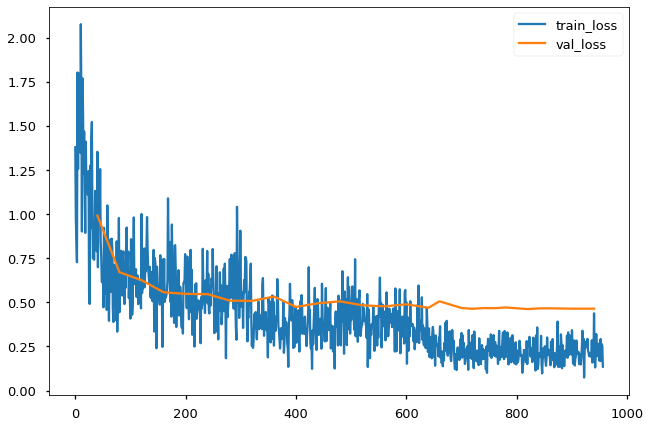

  Model#7  
Epoch: 1/3
		1#[41/319]: train loss - 1.4064881801605225 | val loss - 0.8458569645881653
		Val loss decreased from 0.8458569645881653 to 0.8458569645881653
		1#[81/319]: train loss - 0.6832683086395264 | val loss - 0.7058394551277161
		Val loss decreased from 0.7058394551277161 to 0.7058394551277161
		1#[121/319]: train loss - 0.6677465438842773 | val loss - 0.7163748741149902
		1#[161/319]: train loss - 0.6254526972770691 | val loss - 0.6007320284843445
		Val loss decreased from 0.6007320284843445 to 0.6007320284843445
		1#[201/319]: train loss - 0.5940797924995422 | val loss - 0.5873533487319946
		Val loss decreased from 0.5873533487319946 to 0.5873533487319946
		1#[241/319]: train loss - 0.6155588626861572 | val loss - 0.5792421698570251
		Val loss decreased from 0.5792421698570251 to 0.5792421698570251
		1#[281/319]: train loss - 0.5662884712219238 | val loss - 0.664721667766571
The epoch took 313.3268527984619 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.56283587217330

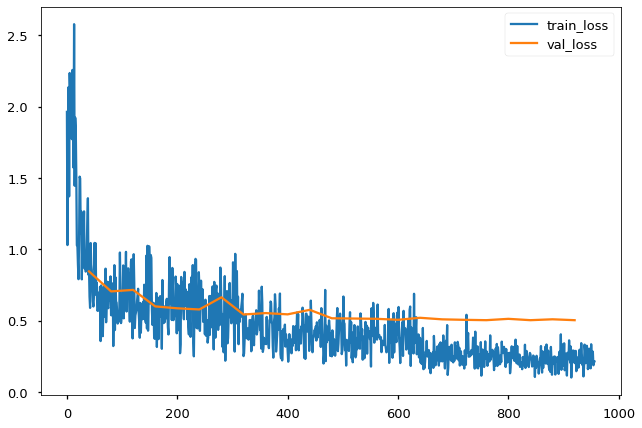

  Model#8  
Epoch: 1/3
		1#[41/319]: train loss - 1.6059777736663818 | val loss - 0.8996478319168091
		Val loss decreased from 0.8996478319168091 to 0.8996478319168091
		1#[81/319]: train loss - 0.8508851528167725 | val loss - 0.8267087936401367
		Val loss decreased from 0.8267087936401367 to 0.8267087936401367
		1#[121/319]: train loss - 0.6845571398735046 | val loss - 0.5822027921676636
		Val loss decreased from 0.5822027921676636 to 0.5822027921676636
		1#[161/319]: train loss - 0.6353668570518494 | val loss - 0.7270152568817139
		1#[201/319]: train loss - 0.6039906144142151 | val loss - 0.6667667627334595
		1#[241/319]: train loss - 0.6289458274841309 | val loss - 0.6140329241752625
		1#[281/319]: train loss - 0.6934819221496582 | val loss - 0.6872063875198364
The epoch took 304.67315697669983 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.5739762783050537 | val loss - 0.515475332736969
		Val loss decreased from 0.515475332736969 to 0.515475332736969
		2#[42/319]: train loss - 0.4731

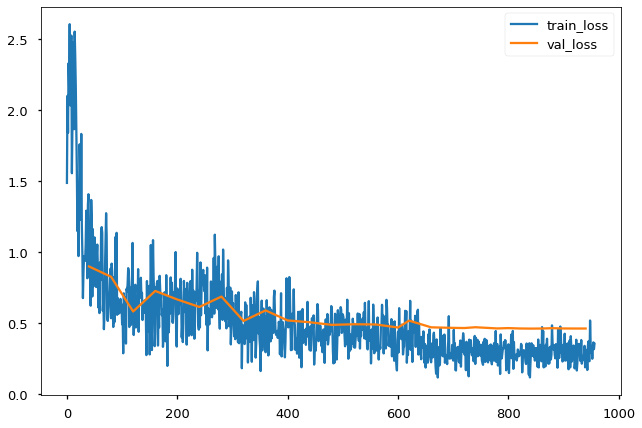

  Model#9  
Epoch: 1/3
		1#[41/319]: train loss - 1.0519522428512573 | val loss - 0.7020860314369202
		Val loss decreased from 0.7020860314369202 to 0.7020860314369202
		1#[81/319]: train loss - 0.7262618541717529 | val loss - 0.5877284407615662
		Val loss decreased from 0.5877284407615662 to 0.5877284407615662
		1#[121/319]: train loss - 0.6747657656669617 | val loss - 0.6274033188819885
		1#[161/319]: train loss - 0.6124123334884644 | val loss - 0.5087348222732544
		Val loss decreased from 0.5087348222732544 to 0.5087348222732544
		1#[201/319]: train loss - 0.5993611812591553 | val loss - 0.5370930433273315
		1#[241/319]: train loss - 0.7561626434326172 | val loss - 0.7351974844932556
		1#[281/319]: train loss - 0.6793310046195984 | val loss - 0.5684472918510437
The epoch took 304.54849457740784 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.501610517501831 | val loss - 0.5539228320121765
		2#[42/319]: train loss - 0.4408409297466278 | val loss - 0.49891749024391174
		Val loss decrease

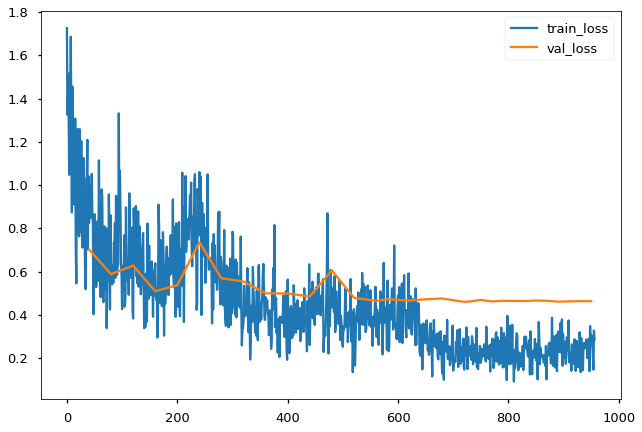

  Model#10  
Epoch: 1/3
		1#[41/319]: train loss - 1.231011152267456 | val loss - 0.9941768646240234
		Val loss decreased from 0.9941768646240234 to 0.9941768646240234
		1#[81/319]: train loss - 0.729894757270813 | val loss - 0.6918388605117798
		Val loss decreased from 0.6918388605117798 to 0.6918388605117798
		1#[121/319]: train loss - 0.6233116984367371 | val loss - 0.5956891775131226
		Val loss decreased from 0.5956891775131226 to 0.5956891775131226
		1#[161/319]: train loss - 0.656604528427124 | val loss - 0.6359787583351135
		1#[201/319]: train loss - 0.6510024070739746 | val loss - 0.5616533756256104
		Val loss decreased from 0.5616533756256104 to 0.5616533756256104
		1#[241/319]: train loss - 0.6190206408500671 | val loss - 0.6402584910392761
		1#[281/319]: train loss - 0.5240445137023926 | val loss - 0.5387990474700928
		Val loss decreased from 0.5387990474700928 to 0.5387990474700928
The epoch took 311.7204875946045 sec..
Epoch: 2/3
		2#[2/319]: train loss - 0.536621749401092

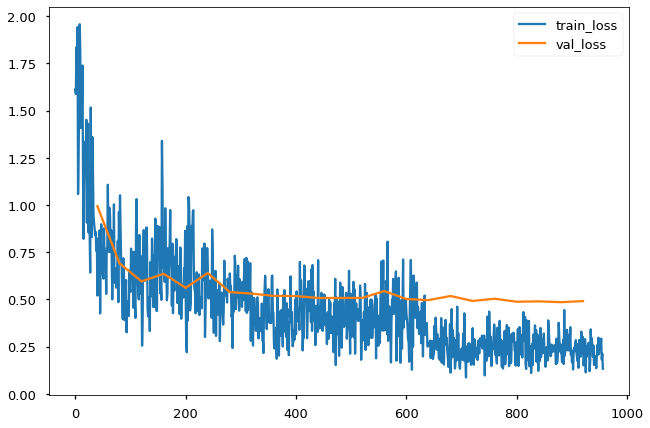

Best val losses: [0.4362313747406006, 0.47606754302978516, 0.4572177827358246, 0.4451853632926941, 0.4309763014316559, 0.46159735321998596, 0.5041005611419678, 0.46151965856552124, 0.45956647396087646, 0.4856024384498596]
Avg val loss: 0.46180648505687716


In [10]:
best_scores = []

for model_num in range(10): 
    print(f'{bb_}{w_}  Model#{model_num+1}  {sr_}')

    tokenizer = AutoTokenizer.from_pretrained(Config.model_name)
    config = AutoConfig.from_pretrained(Config.model_name)
    config.update({
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7,
            "output_hidden_states": True
            }) 

    train_dl = make_dataloader(kfold_df[kfold_df.fold!=model_num], tokenizer)
    val_dl = make_dataloader(kfold_df[kfold_df.fold==model_num], tokenizer, is_train=False)

#     train_dl = make_dataloader(train_df, tokenizer)
#     val_dl = make_dataloader(val_df, tokenizer, is_train=False)

    transformer = AutoModel.from_pretrained(Config.model_name, config=config)  

    model = CLRPModel(transformer, config)
    
    model = model.to(Config.device)
    optimizer = create_optimizer(model)
    scaler = GradScaler()
#     optimizer = optim.AdamW(model.parameters(), lr=Config.lr)
    scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_training_steps=Config.epochs * len(train_dl),
            num_warmup_steps=len(train_dl) * Config.epochs * 0.11)  

    criterion = mse_loss

    trainer = Trainer(train_dl, val_dl, model, optimizer, scheduler, scaler, criterion, model_num)
    record_info, best_val_loss = trainer.run()
    best_scores.append(best_val_loss)    
    
    steps, train_losses = list(zip(*record_info['train_loss']))
    plt.plot(steps, train_losses, label='train_loss')
    steps, val_losses = list(zip(*record_info['val_loss']))
    plt.plot(steps, val_losses, label='val_loss')
    plt.legend()
    plt.show()
    
print('Best val losses:', best_scores)
print('Avg val loss:', np.array(best_scores).mean())
!date '+%A %W %Y %X' > execution_time